In [2]:
import torch
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# from io import BytesIO
# from urllib.request import urlopen
# from zipfile import ZipFile

# # url = 'https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/data_loader/PeMSD7_Full.zip'
# url = 'https://github.com/VeritasYin/STGCN_IJCAI-18/blob/master/dataset/PeMSD7_Full.zip'
# with urlopen(url) as zurl:
#     with ZipFile(BytesIO(zurl.read())) as zfile:
#         zfile.extractall('.')

In [10]:
import pandas as pd

speeds = pd.read_csv('PeMSD7_V_228.csv', names=range(0,228))
distances = pd.read_csv('PeMSD7_W_228.csv', names=range(0,228))
speeds
# distances

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,71.1,66.0,64.6,65.6,67.1,71.9,68.6,67.7,65.8,40.9,...,69.1,70.9,65.0,64.5,66.6,66.6,65.0,69.3,67.7,68.9
1,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
2,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
3,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
4,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12667,70.3,65.9,70.2,62.1,66.8,66.0,64.0,64.8,24.6,66.5,...,66.0,55.6,29.9,63.8,64.5,62.8,3.8,70.2,68.1,19.3
12668,69.9,54.0,68.2,62.2,67.4,65.8,64.4,61.3,35.1,69.2,...,66.8,62.8,29.9,62.9,66.6,63.0,3.5,68.2,68.3,18.9
12669,68.9,37.9,68.8,66.3,69.4,66.6,65.0,60.1,38.5,68.7,...,66.4,65.4,29.9,66.3,68.1,62.6,3.5,68.7,67.5,19.7
12670,69.2,37.8,68.7,63.6,68.5,66.2,64.1,60.9,40.5,68.5,...,67.6,68.9,30.2,64.8,68.2,63.1,3.7,67.7,67.4,19.5


In [11]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Traffic Speed')

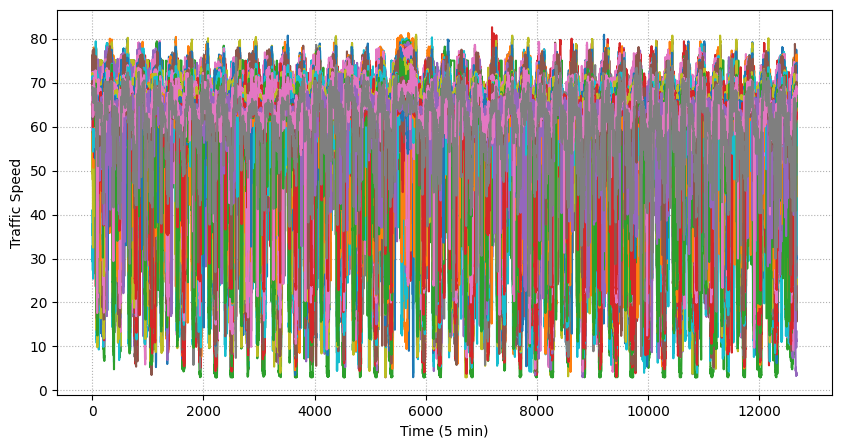

In [13]:
plt.figure(figsize=(10,5))
plt.plot(speeds)
plt.grid(linestyle=':')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic Speed')

In [14]:
mean = speeds.mean(axis=1)
std = speeds.std(axis=1)


Text(0, 0.5, 'Traffic Speed')

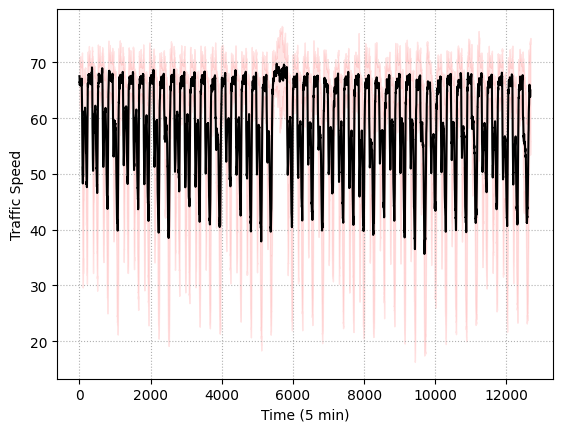

In [15]:
plt.plot(mean, 'k-')
plt.fill_between(mean.index, mean-std, mean+std, color = 'r', alpha=0.1)
plt.grid(linestyle=':')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic Speed')

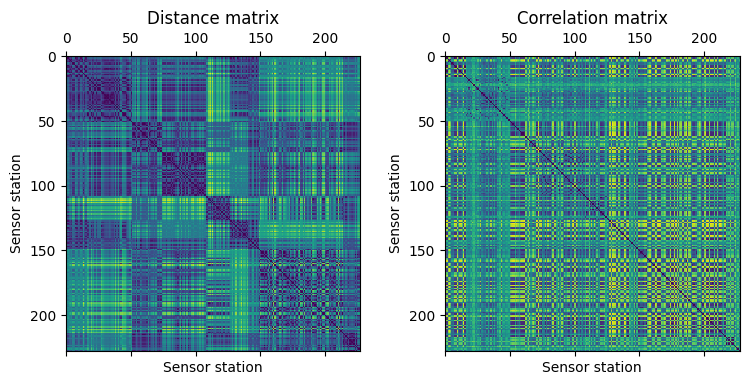

In [16]:
# We can also visualize the correlation between the timeseries in different routes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)
ax1.matshow(distances)
ax1.set_xlabel("Sensor station")
ax1.set_ylabel("Sensor station")
ax1.title.set_text("Distance matrix")
ax2.matshow(-np.corrcoef(speeds.T))
ax2.set_xlabel("Sensor station")
ax2.set_ylabel("Sensor station")
ax2.title.set_text("Correlation matrix")

Text(0, 0.5, 'Sensor station')

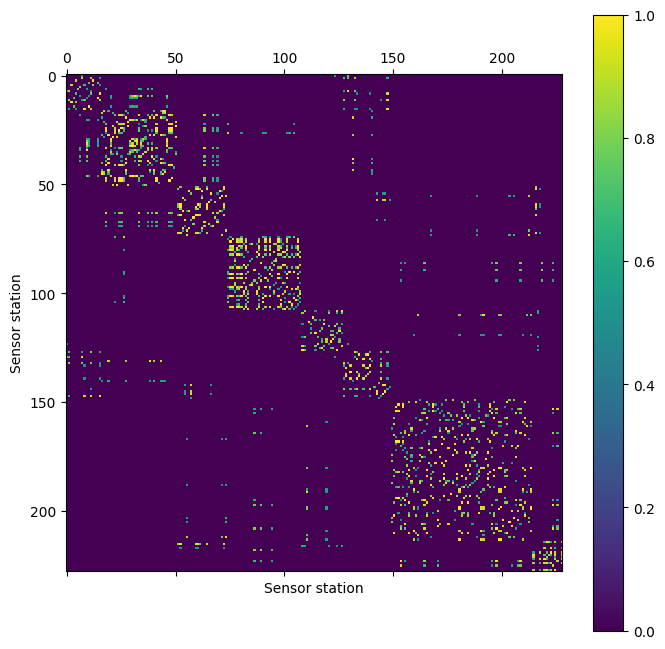

In [18]:
# preprocess the dataset, tabular->graph via adjacency mat through distance matrix
# weights between 0 and 1

def compute_adj(distances, sigma2=0.1, epsilon=0.5):
    d = distances.to_numpy() / 10000.
    d2 = d * d
    n = distances.shape[0]  
    w_mask = np.ones([n, n]) - np.identity(n)
    return np.exp(-d2 / sigma2) * (np.exp(-d2 / sigma2) >= epsilon) * w_mask

adj = compute_adj(distances)


plt.figure(figsize=(8, 8))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")



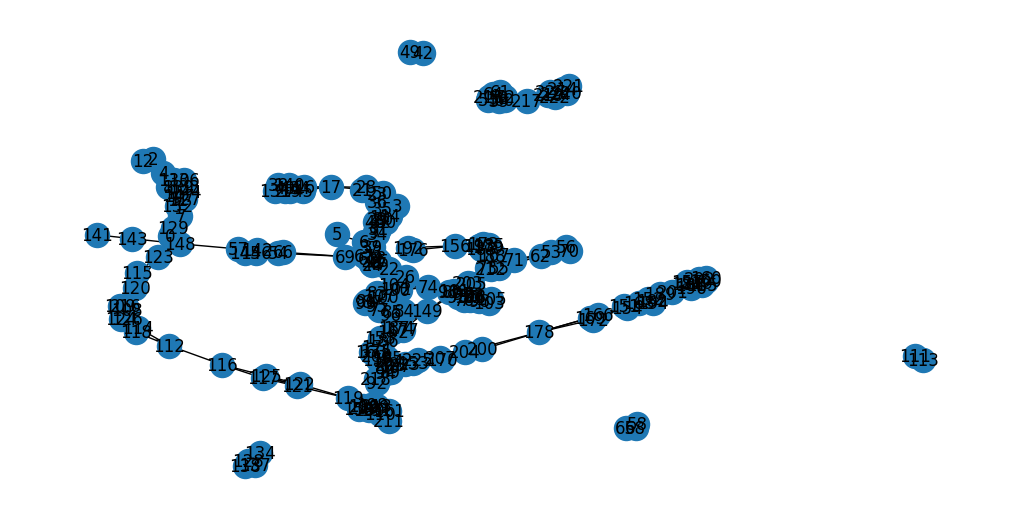

In [20]:
import networkx as nx

def plot_graph(adj):
    plt.figure(figsize=(10,5))
    rows, cols = np.where(adj > 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels = True)
    plt.show()

plot_graph(adj)

In [22]:
# Apply z-score
def zscore(x, mean, std):
    return (x - mean) / std

speeds_norm = zscore(speeds, speeds.mean(axis=0), speeds.std(axis=0))

# Create dataset
lags = 24
horizon = 48
xs = []
ys = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    xs.append(speeds_norm.to_numpy()[i-lags:i].T)
    ys.append(speeds_norm.to_numpy()[i+horizon-1])

# Convert adjacency matrix to edge_index (COO format)
edge_index = (np.array(adj) > 0).nonzero()
edge_index

(array([  0,   0,   0, ..., 227, 227, 227], dtype=int64),
 array([  7, 123, 129, ..., 221, 222, 224], dtype=int64))

In [24]:
# create temporal graph

from torch_geometric_temporal.signal import StaticGraphTemporalSignal

edge_index = (np.array(adj) > 0).nonzero()
edge_weight = (adj[adj > 0])
dataset = StaticGraphTemporalSignal(edge_index, adj[adj > 0], xs, ys)
dataset[0]


c:\Users\chatu\miniconda3\envs\graph\Lib\site-packages\torch_geometric_temporal\signal\static_graph_temporal_signal.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.LongTensor(self.edge_index)


Data(x=[228, 24], edge_index=[2, 1664], edge_attr=[1664], y=[228])

In [27]:
# split them
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)